# 10. Denoising Autoencoder for Image Classifier pretraining

_Exercise: Try using a denoising autoencoder to pretrain an image classifier. You can use MNIST (the simplest option), or a more complex image dataset such as [CIFAR10](https://homl.info/122) if you want a bigger challenge. Regardless of the dataset you're using, follow these steps:_
* Split the dataset into a training set and a test set. Train a deep denoising autoencoder on the full training set.
* Check that the images are fairly well reconstructed. Visualize the images that most activate each neuron in the coding layer.
* Build a classification DNN, reusing the lower layers of the autoencoder. Train it using only 500 images from the training set. Does it perform better with or without pretraining?

## Prepare environment

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import keras
from keras import layers

from matplotlib import pyplot as plt

import numpy as np

2025-03-25 14:48:27.193880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742910507.273690  110068 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742910507.292510  110068 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 14:48:27.384982: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

## MNIST

### Split the dataset into a training set and a test set.

In [3]:
train, test = tfds.as_numpy(
    tfds.load(
        "mnist",
        split=["train", "test"],
        shuffle_files=True,
        as_supervised=True,
        batch_size=-1,
    )
)

I0000 00:00:1742904252.148225   78326 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1
2025-03-25 13:04:13.249838: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


In [41]:
X_train_full, y_train_full, X_test, y_test = train[0], train[1], test[0], test[1]

In [42]:
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [43]:
for image in X_train[:5]:
  print(image.shape)

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


In [44]:
for image in X_test[:5]:
  print(image.shape)

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


In [46]:
y_train[:5]

array([4, 1, 0, 7, 8])

In [47]:
y_test[:5]

array([2, 0, 4, 8, 7])

### Train a deep denoising autoencoder on the full training set.

In [7]:
dropout_encoder = keras.Sequential([
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(100, activation="relu"),
    layers.Dense(30, activation="relu")
])
dropout_decoder = keras.Sequential([
    layers.Dense(100, activation="relu"),
    layers.Dense(28 * 28),
    layers.Reshape([28, 28])
])
dropout_ae = keras.Sequential([dropout_encoder, dropout_decoder])

dropout_ae.compile(loss="mse", optimizer="nadam")
history = dropout_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10


I0000 00:00:1742904259.420314   78415 service.cc:148] XLA service 0x7f25604e51b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742904259.420359   78415 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
2025-03-25 13:04:19.476253: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742904259.568132   78415 cuda_dnn.cc:529] Loaded cuDNN version 90700


  43/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0933  

I0000 00:00:1742904261.941956   78415 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0439 - val_loss: 0.0259
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0280 - val_loss: 0.0237
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0259 - val_loss: 0.0226
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0247 - val_loss: 0.0216
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0238 - val_loss: 0.0210
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0232 - val_loss: 0.0206
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0228 - val_loss: 0.0203
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0225 - val_loss: 0.0200
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0223 - val_loss: 0.0198
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0221 - val_loss: 0.0197


### Check that the images are fairly well reconstructed

In [8]:
def plot_reconstructions(model, images, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step


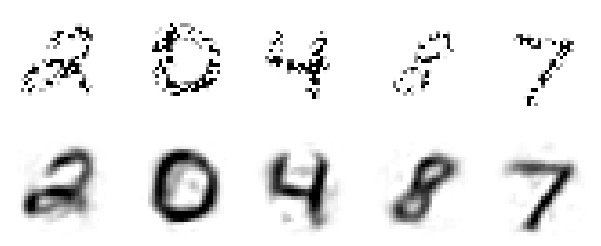

In [13]:
dropout = layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_test, training=True))
plt.show()

### Visualize the images that most activate each neuron in the coding layer

In [10]:
def select_representative_images(x_test, y_test):
    """
    Select one representative image for each digit class
    
    Args:
        x_test (np.array): Test images
        y_test (np.array): Test labels
    
    Returns:
        tuple: Selected images and their corresponding labels
    """
    # Unique classes (0-9)
    classes = np.unique(y_test)
    
    # Storage for selected images
    selected_images = []
    selected_labels = []
    
    for digit in classes:
        # Find indices of images with this digit
        digit_indices = np.where(y_test == digit)[0]
        
        # Select first image of this digit (you could use random selection too)
        first_image_index = digit_indices[0]
        
        selected_images.append(x_test[first_image_index])
        selected_labels.append(y_test[first_image_index])
    
    return (np.array(selected_images), np.array(selected_labels))

def visualize_neuron_activations_per_class(encoder, x_test, y_test):
    """
    Visualize neuron activations for representative images of each class
    
    Args:
        encoder (keras.Model): Trained encoder model
        x_test (np.array): Test images
        y_test (np.array): Test labels
    """
    # Select one image per class
    class_images, class_labels = select_representative_images(x_test, y_test)
    
    # Get neuron activations for these images
    activations = encoder.predict(class_images)
    
    # Visualization
    plt.figure(figsize=(15, 6))
    
    # Images
    for i in range(len(class_images)):
        plt.subplot(2, 10, i + 1)
        plt.imshow(class_images[i].squeeze(), cmap='gray')
        plt.title(f'Digit: {class_labels[i]}')
        plt.axis('off')
    
    # Neuron Activations
    plt.subplot(2, 1, 2)
    plt.imshow(activations, aspect='auto', cmap='viridis')
    plt.title('Neuron Activations per Digit Class')
    plt.xlabel('Neuron Index')
    plt.ylabel('Digit Class')
    plt.colorbar(label='Activation Strength')
    
    # Add class labels to y-axis
    plt.yticks(range(len(class_labels)), [str(label) for label in class_labels])
    plt.xticks(range(len(activations[0])))
    
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


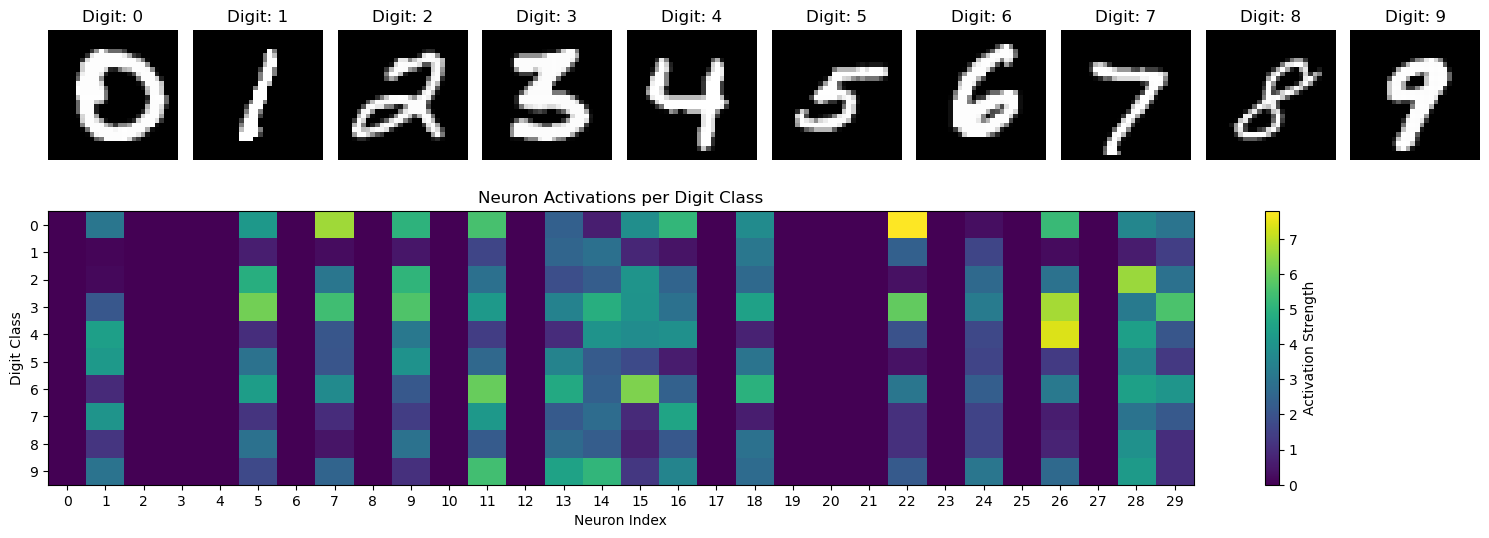

In [27]:
visualize_neuron_activations_per_class(dropout_encoder, X_test, y_test)

### Build a classification DNN, reusing the lower layers of the autoencoder.

In [32]:
num_classes = len(np.unique(y_test))
num_classes

10

In [56]:
model = keras.Sequential()

dropout_encoder.trainable = False
model.add(dropout_encoder)

for _ in range(20):
    model.add(layers.Dense(100, kernel_initializer="he_normal"))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("swish"))

model.add(layers.Dense(num_classes, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

### Train it using only 500 images from the training set.

In [57]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True
)

model.fit(
    X_train[:500],
    y_train[:500],
    epochs=100,
    validation_data=(X_valid[:500], y_valid[:500]),
    callbacks=[early_stopping_cb],
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 528ms/step - accuracy: 0.0691 - loss: 2.5839 - val_accuracy: 0.1020 - val_loss: 2.3029
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1678 - loss: 2.3444 - val_accuracy: 0.0940 - val_loss: 2.3502
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1867 - loss: 2.2298 - val_accuracy: 0.1000 - val_loss: 2.3143
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2963 - loss: 2.0872 - val_accuracy: 0.0900 - val_loss: 2.3556
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3276 - loss: 1.9635 - val_accuracy: 0.1240 - val_loss: 2.3063
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3720 - loss: 1.8370 - val_accuracy: 0.1320 - val_loss: 2.2670
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4592 - loss: 1.6592 - val_accuracy: 0.1540 - val_loss: 2.2124
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4933 - loss: 1.5575 - val_accuracy: 

### Does it perform better with or without pretraining?

In [60]:
model_without_pretraining = keras.Sequential()

model_without_pretraining.add(layers.Flatten())

for _ in range(20):
    model_without_pretraining.add(layers.Dense(100, kernel_initializer="he_normal"))
    model_without_pretraining.add(layers.BatchNormalization())
    model_without_pretraining.add(layers.Activation("swish"))

model_without_pretraining.add(layers.Dense(num_classes, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model_without_pretraining.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [61]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True
)

model_without_pretraining.fit(
    X_train[:500],
    y_train[:500],
    epochs=100,
    validation_data=(X_valid[:500], y_valid[:500]),
    callbacks=[early_stopping_cb],
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 462ms/step - accuracy: 0.1440 - loss: 2.4825 - val_accuracy: 0.0960 - val_loss: 2.3031
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1934 - loss: 2.2393 - val_accuracy: 0.0960 - val_loss: 2.3058
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2355 - loss: 2.0758 - val_accuracy: 0.0960 - val_loss: 2.3111
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3411 - loss: 1.9568 - val_accuracy: 0.0960 - val_loss: 2.3188
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4188 - loss: 1.8328 - val_accuracy: 0.0960 - val_loss: 2.3289
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4956 - loss: 1.6376 - val_accuracy: 0.0960 - val_loss: 2.3378
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5841 - loss: 1.4647 - val_accuracy: 0.0960 - val_loss: 2.3424
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6937 - loss: 1.2221 - val_accuracy: 

In [59]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7862 - loss: 0.8035


[0.7895389199256897, 0.7896000146865845]

In [62]:
model_without_pretraining.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3314 - loss: 2.1469


[2.1241016387939453, 0.33480000495910645]

# CIFAR10

In [3]:
train, test = tfds.as_numpy(
    tfds.load(
        "cifar10",
        split=["train", "test"],
        shuffle_files=True,
        as_supervised=True,
        batch_size=-1,
    )
)

I0000 00:00:1742910527.650656  110068 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2874 MB memory:  -> device: 0, name: Quadro P600, pci bus id: 0000:01:00.0, compute capability: 6.1
2025-03-25 14:48:48.869161: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


In [4]:
X_train_full, y_train_full, X_test, y_test = train[0], train[1], test[0], test[1]

In [5]:
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [6]:
dropout_encoder = keras.Sequential([
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(100, activation="relu"),
    layers.Dense(30, activation="relu")
])
dropout_decoder = keras.Sequential([
    layers.Dense(100, activation="relu"),
    layers.Dense(32 * 32 * 3),
    layers.Reshape([32, 32, 3])
])
dropout_ae = keras.Sequential([dropout_encoder, dropout_decoder])

dropout_ae.compile(loss="mse", optimizer="nadam")
history = dropout_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10


I0000 00:00:1742910535.798385  110223 service.cc:148] XLA service 0x7fe510004090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742910535.798547  110223 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
2025-03-25 14:48:55.857285: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742910535.965134  110223 cuda_dnn.cc:529] Loaded cuDNN version 90700


  37/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1386  

I0000 00:00:1742910538.315896  110223 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0392 - val_loss: 0.0261
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0262 - val_loss: 0.0274
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0261 - val_loss: 0.0256
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0260 - val_loss: 0.0256
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0259 - val_loss: 0.0254
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0258 - val_loss: 0.0252
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0258 - val_loss: 0.0260
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0257 - val_loss: 0.0252
Epoch 9/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0256 - val_loss: 0.0249
Epoch 10/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0256 - val_loss: 0.0252


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


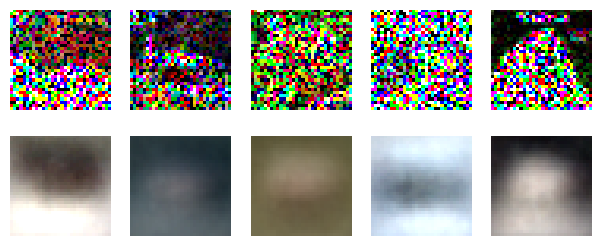

In [9]:
dropout = layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_test, training=True))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


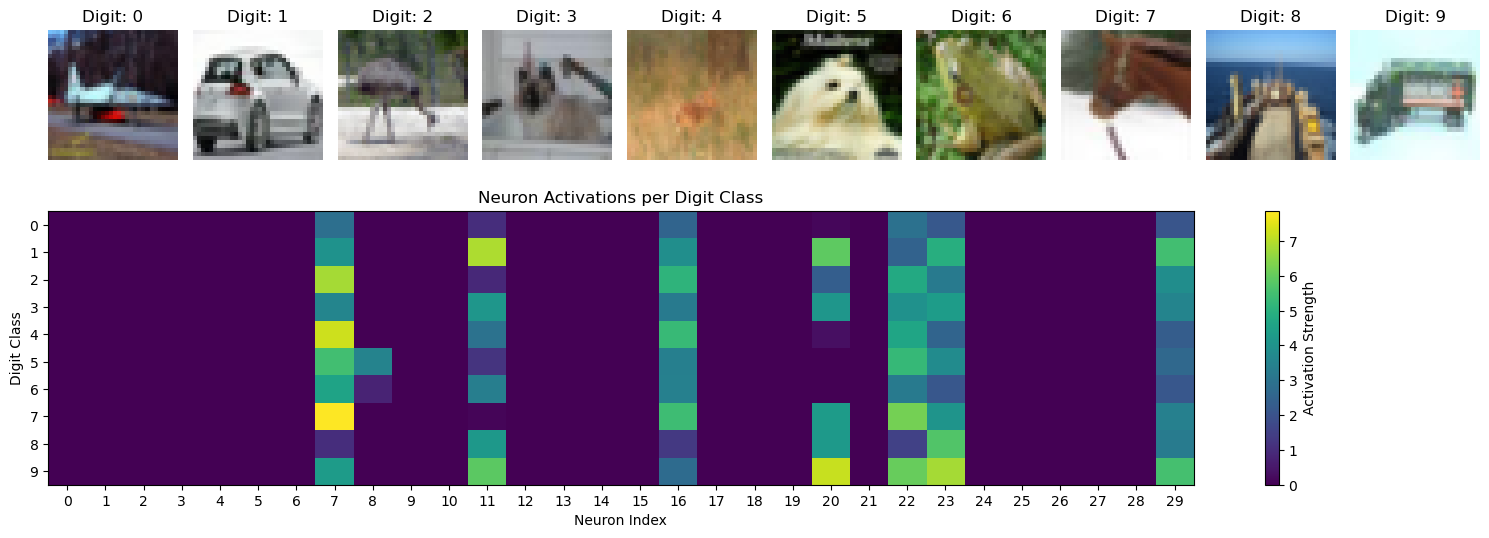

In [11]:
visualize_neuron_activations_per_class(dropout_encoder, X_test, y_test)

In [12]:
num_classes = len(np.unique(y_test))
num_classes

10

In [13]:
model = keras.Sequential()

dropout_encoder.trainable = False
model.add(dropout_encoder)

for _ in range(20):
    model.add(layers.Dense(100, kernel_initializer="he_normal"))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("swish"))

model.add(layers.Dense(num_classes, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [15]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True
)

model.fit(
    X_train[:500],
    y_train[:500],
    epochs=100,
    validation_data=(X_valid[:500], y_valid[:500]),
    callbacks=[early_stopping_cb],
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 549ms/step - accuracy: 0.1056 - loss: 2.6311 - val_accuracy: 0.1060 - val_loss: 2.3375
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1086 - loss: 2.4719 - val_accuracy: 0.1200 - val_loss: 2.3301
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1530 - loss: 2.3352 - val_accuracy: 0.1300 - val_loss: 2.3242
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1674 - loss: 2.2768 - val_accuracy: 0.1300 - val_loss: 2.3224
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2205 - loss: 2.1964 - val_accuracy: 0.1280 - val_loss: 2.3210
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2760 - loss: 2.0781 - val_accuracy: 0.1220 - val_loss: 2.3154
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2559 - loss: 2.0344 - val_accuracy: 0.0920 - val_loss: 2.3187
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2836 - loss: 2.0039 - val_accuracy: 

In [16]:
model_without_pretraining = keras.Sequential()

model_without_pretraining.add(layers.Flatten())

for _ in range(20):
    model_without_pretraining.add(layers.Dense(100, kernel_initializer="he_normal"))
    model_without_pretraining.add(layers.BatchNormalization())
    model_without_pretraining.add(layers.Activation("swish"))

model_without_pretraining.add(layers.Dense(num_classes, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model_without_pretraining.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [17]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True
)

model_without_pretraining.fit(
    X_train[:500],
    y_train[:500],
    epochs=100,
    validation_data=(X_valid[:500], y_valid[:500]),
    callbacks=[early_stopping_cb],
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 422ms/step - accuracy: 0.0840 - loss: 2.5909 - val_accuracy: 0.0860 - val_loss: 2.3048
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1046 - loss: 2.4370 - val_accuracy: 0.0840 - val_loss: 2.3030
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1220 - loss: 2.3950 - val_accuracy: 0.0780 - val_loss: 2.3121
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1317 - loss: 2.3328 - val_accuracy: 0.0980 - val_loss: 2.4222
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1875 - loss: 2.2605 - val_accuracy: 0.0880 - val_loss: 2.3792
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1795 - loss: 2.2085 - val_accuracy: 0.0800 - val_loss: 2.3377
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2151 - loss: 2.1433 - val_accuracy: 0.0860 - val_loss: 2.3570
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1949 - loss: 2.1900 - val_accuracy: 

In [18]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1308 - loss: 2.3264


[2.3290109634399414, 0.1298000067472458]

In [19]:
model_without_pretraining.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1000 - loss: 2.2986


[2.2997865676879883, 0.10140000283718109]